# [프로젝트] AI를 활용한 마스크 착용 여부 판별 서비스 구현하기
---


## 프로젝트 목표
---
- 웹캠을 활용하여 인공지능 프로젝트에 필요한 데이터셋을 수집하는 방법을 학습합니다.
- 인공지능 모델을 활용하여 마스크 착용 여부를 판별하는 서비스를 구현합니다. 
- 인공지능을 활용할 수 있는 다양한 방법을 고민하고 직접 경험합니다.


## 프로젝트 목차
---

1. **데이터 수집하기:** 웹캠을 활용하여 얼굴 데이터셋을 수집합니다.

2. **데이터 전처리(1):** 인공지능 모델 학습에 필요한만큼 얼굴 데이터셋을 준비합니다.

3. **데이터 시각화:** 이미지 데이터셋의 크기를 시각화하여 데이터셋 크기 조정을 위한 지표를 확인합니다. 

4. **데이터 전처리(2):** 머신러닝 모델에 필요한 입력값 형식으로 이미지 데이터의 크기를 통일시킵니다.

5. **딥러닝 모델 만들고 학습하기:** 마스크 착용 여부 판별을 위한 CNN 모델을 구축하고, 데이터를 학습시킵니다.

6. **결과 확인:** 학습시킨 모델을 활용하여 테스트 데이터에 대한 성능을 확인합니다.

7. **더 해보기 - 데이터 증강 기법:** 학습시킨 모델을 활용하여 테스트 데이터에 대한 성능을 확인합니다.



## 프로젝트 개요
---


마스크 착용 여부를 판별하는 인공지능 모델을 구축하기 위하여 내 얼굴 데이터셋을 직접 수집해보고, 실시간으로 웹캠을 활용한 얼굴 데이터가 주어졌을 때, 마스크 착용 여부를 판별하는 서비스를 구축하는 프로젝트를 진행합니다.

## 1. 데이터 수집하기
---
모델에 학습을 시키기 위해서는 마스크를 쓴 사진과 쓰지 않은 사진 그리고 착용 유무에 따른 레이블 데이터 셋트가 필요합니다. 

그러나, 현재는 개인정보 등의 이슈로 인하여 마스크 데이터셋을 수집하기에는 어렵기 때문에, 웹캠을 활용하여 본인의 얼굴 데이터셋을 수집하여 해당 프로젝트에 활용해보겠습니다. 

### 1.1 얼굴 데이터 셋트 만들기 
---
직접 얼굴 데이터 셋트를 만들기 위해 얼굴 인식을 간편하게 해주는 파이썬 라이브러리인 `cvlib`를 활용하였습니다. `cvlib` 라이브러리를 사용하기 위해서는 `opencv-python`과 `cvlib` 라이브러리가 설치되어야 하기 때문에, 먼저 `pip install` 명령으로 이 라이브러리들을 한꺼번에 설치해보겠습니다.

#### 1.1.1 라이브러리 임포트 하기
우선 이 프로젝트에서 사용할 라이브러리를 모두 임포트 합니다. 

In [ ]:
!pip install opencv-python
!pip install cvlib

In [ ]:
import cv2
import cvlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import array_to_img, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomCrop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

### 1.1.2 웹캠 연결하기
얼굴 데이터를 캡쳐하기 위해서 기기에 연결된 웹캠을 사용해보겠습니다. 
엘리스 환경에서 웹캠을 사용하기 위해서는 `ipywebrtc`라이브러리가 필요합니다. 

해당 라이브러리를 설치한 후, 직접 웹캠에서 본인의 얼굴을 캡쳐해보도록 하겠습니다. 

In [ ]:
!pip install ipywebrtc

In [ ]:
from ipywebrtc import CameraStream, ImageRecorder

`CameraStream` 을 활용하여 웹캠을 연결하고, `ImageRecorder` 를 활용하여 연결된 웹캠에서 자신의 얼굴을 캡쳐합니다. 

In [ ]:
camera = CameraStream(constraints=
                      {'facing_mode': 'user',
                       'audio': False,
                       'video': { 'width': 640, 'height': 480 }
                       })
camera

CameraStream(constraints={'facing_mode': 'user', 'audio': False, 'video': {'width': 640, 'height': 480}})

실시간으로 연결된 웹캠이 촬영하고 있는 모습을 확인할 수 있습니다.

#### 1.1.2 웹캠으로 사진 캡쳐하기
`ImageRecorder`를 사용하여 웹캠으로 사진을 캡쳐할 수 있습니다. 

왼쪽 카메라 버튼을 누르면 웹캠에서 실시간으로 촬영된 모습을 사진으로 캡쳐하고, 우측 다운로드 버튼을 누르면 캡쳐된 사진을 png 형식으로 저장할 수 있습니다. 

In [ ]:
image_recorder = ImageRecorder(stream=camera)
image_recorder

ImageRecorder(image=Image(value=b''), stream=CameraStream(constraints={'facing_mode': 'user', 'audio': False, …

캡쳐한 사진을 파이썬에서 이미지 데이터셋을 활용하기 위한 라이브러리인 `PIL`의 Image 형식으로 변환하고, 변환 결과를 확인합니다.

In [ ]:
import PIL.Image
import PIL.ImageFilter
import io

im = PIL.Image.open(io.BytesIO(image_recorder.image.value))

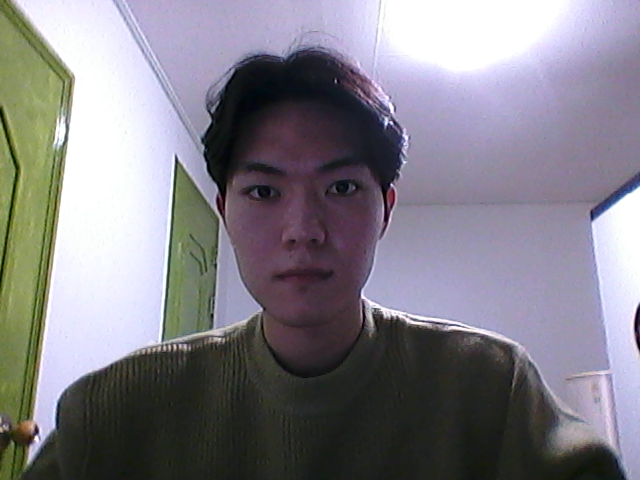

In [ ]:
im

이미지의 색상 모드를 RGBA 에서 RGB 로 변환해줍니다. RGBA의 A는 alpha 의 약자로 픽셀의 투명도를 의미합니다. 일반적으로 이미지 데이터를 사용할 때에 RGB 색상 모드를 이용하므로 A 값을 제거해주겠습니다.

In [ ]:
print('변환 전 이미지의 컬러 모드:', im.mode)
im = im.convert("RGB")
print('변환 후 이미지의 컬러 모드:', im.mode)

변환 전 이미지의 컬러 모드: RGBA
변환 후 이미지의 컬러 모드: RGB


또한, numpy array형식으로 변환하고, 변환한 numpy array 데이터를 다시 이미지로 변환하여 확인해봅니다.

In [ ]:
pimg = np.array(im)

In [ ]:
pimg.shape

(480, 640, 3)

In [ ]:
pimg

array([[[101, 111,  51],
        [109, 119,  60],
        [104, 113,  56],
        ...,
        [174, 158, 198],
        [164, 148, 189],
        [167, 151, 193]],

       [[101, 109,  53],
        [108, 116,  61],
        [108, 116,  62],
        ...,
        [174, 160, 201],
        [165, 151, 192],
        [169, 155, 197]],

       [[ 99, 105,  58],
        [104, 110,  62],
        [107, 113,  65],
        ...,
        [173, 162, 205],
        [172, 161, 203],
        [170, 160, 201]],

       ...,

       [[ 85,  99,  41],
        [ 85,  98,  38],
        [ 88, 101,  39],
        ...,
        [157, 154, 185],
        [156, 153, 183],
        [154, 152, 182]],

       [[ 78,  93,  31],
        [ 80,  94,  32],
        [ 85,  98,  36],
        ...,
        [156, 153, 183],
        [156, 153, 183],
        [154, 152, 182]],

       [[ 77,  92,  28],
        [ 81,  95,  32],
        [ 84,  97,  35],
        ...,
        [154, 152, 182],
        [154, 152, 182],
        [154, 152, 182]]

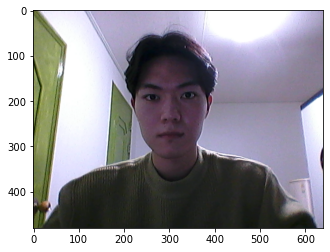

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(pimg)
plt.show() 

#### 1.1.3 얼굴 탐지하기
`cvlib.detect_face()` 함수를 사용하면 이미지 데이터 속 얼굴 영역을 탐지할 수 있습니다.

`detect_face()` 함수에 이미지를 전달하면 두개의 값을 튜플로 리턴하는데, 첫 번째 값은 얼굴의 위치를 나타내고, 두 번째 값은 해당 영역이 얼굴일 확률을 나타냅니다. 

In [ ]:
faces, confidences = cvlib.detect_face(pimg)
print('얼굴의 위치:', faces)
print('확신도:', confidences)

얼굴의 위치: [[217, 106, 389, 325]]
확신도: [0.9999957]


`faces` 는 얼굴 영역을 나타내는 사각형의 [ [왼쪽 위 x 좌표, 왼쪽 위 y 좌표, 오른쪽 아래 x 좌표, 오른쪽 아래 y 좌표] ] 를 나타냅니다. 해당 영역을 crop 하여 이미지에서 얼굴 부분만 추출하여 봅니다.

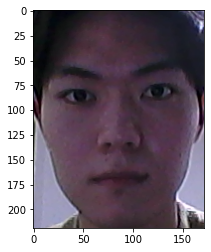

In [ ]:
start_x, start_y, end_x, end_y = faces[0]
face_img = pimg[start_y:end_y, start_x:end_x, :]
plt.imshow(face_img)
plt.show()

#### 이미지 배율 정하기
일반적으로 CNN 모델을 학습하기 위한 이미지는 모두 같은 사이즈를 가지는 것이 좋습니다. 가로세로비가 다른 사진들을 같은 사이즈로 변환 시 이미지 왜곡이 발생 할 수 있으므로, 크롭 영역의 가로세로비를 모두 일정하게 해줍니다. 본 실습에서는 1:1 비를 사용해봅니다.

In [ ]:
# 얼굴이 이미지의 가운데에 위치하도록 crop 하되, crop 영역이 정사각형이 되도록 합니다.
def square_crop(faces): 
    start_x, start_y, end_x, end_y = faces
    height, width = end_y - start_y, end_x - start_x
    if width > height: 
        diff = width - height 
        start_y -= diff//2
        end_y += diff//2
    else: 
        diff = height - width
        start_x -= diff//2
        end_x += diff//2
    return start_x, start_y, end_x, end_y

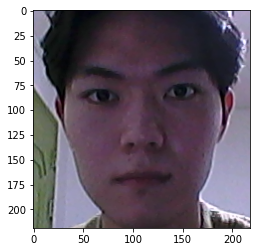

In [ ]:
start_x, start_y, end_x, end_y = square_crop(faces[0])
face_img = pimg[start_y:end_y, start_x:end_x, :]
plt.imshow(face_img)
plt.show()

#### 1.1.4 이미지 저장하기
`cv2.imwrite()` 함수를 사용하면 크롭한 얼굴 영역 이미지를 저장할 수 있습니다. 

첫 번째 인자는 저장할 파일의 위치와 이름을 전달하고, 두 번째 인자는 저장할 이미지를 전달합니다. 
`cvlib.detect_face()` 함수로 찾은 얼굴 위치를 사용해서 얼굴만 추출하여 저장합니다. 

In [ ]:
cv2.imwrite('sample_face.jpg', face_img)

True

#### 1.1.5 웹캠으로 여러 장의 사진 데이터를 수집하기
1.1.1 ~ 1.1.4의 코드를 이용해서 여러 장의 사진 데이터를 캡쳐하고, 저장하는 함수를 구현하였습니다. 

In [ ]:
from ipywidgets import Output, VBox

`numImages`에 촬영하고자 하는 사진의 개수를 입력합니다. (현재는 40개로 설정되어있습니다.)

아래 2개의 코드 셀 실행을 통해 마스크를 착용한 사진과 착용하지 않은 사진 각 40장씩을 촬영합니다.
왼쪽 카메라 버튼을 누르면, 촬영이 시작됩니다. 

먼저, 마스크를 착용하지 않은 사진부터 촬영해봅시다.

In [ ]:
recorder = ImageRecorder(stream=camera)
out = Output()

numImage = 0
numImages = 40

def savePicture(_):
    with out:
        global numImage
        global numImages
        if numImage >= numImages:
            return

        out.append_stdout("Image " + str(numImage) + " captured \n")
        recorder.save("./webcam_nonmask/" + str(numImage) + ".png")
        numImage = numImage + 1
        recorder.recording = True
    
recorder.image.observe(savePicture, names=['value'])
VBox([recorder, out])

그 다음엔, 마스크를 착용한 얼굴 사진을 촬영해보도록 하겠습니다.

In [ ]:
recorder = ImageRecorder(stream=camera)
out = Output()

numImage = 0
numImages = 40

def savePicture(_):
    with out:
        global numImage
        global numImages
        if numImage >= numImages:
            return

        out.append_stdout("Image " + str(numImage) + " captured \n")
        recorder.save("./webcam_mask/" + str(numImage) + ".png")
        numImage = numImage + 1
        recorder.recording = True
    
recorder.image.observe(savePicture, names=['value'])
VBox([recorder, out])

촬영된 사진들이 잘 저장되어있는지, 파일 목록을 출력해봅니다.

In [ ]:
import os

# 마스크 쓴 파일 목록 
path = "./webcam_mask/"
file_list_png_mask = os.listdir(path)
file_list_png_mask = [file for file in file_list_png_mask if file.endswith(".png")]
print('마스크 쓴 이미지 파일 목록: {0}'.format(file_list_png_mask))
print('마스크 쓴 이미지 개수: {0}개'.format(len(file_list_png_mask)))

마스크 쓴 이미지 파일 목록: ['0.png', '1.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '2.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '3.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png']
마스크 쓴 이미지 개수: 40개


In [ ]:
# 마스크 안 쓴 파일 목록 
path = "./webcam_nonmask/"
file_list_png_nonmask = os.listdir(path)
file_list_png_nonmask = [file for file in file_list_png_nonmask if file.endswith(".png")]
print('마스크 쓴 이미지 파일 목록: {0}'.format(file_list_png_nonmask))
print('마스크 쓴 이미지 개수: {0}개'.format(len(file_list_png_nonmask)))

마스크 쓴 이미지 파일 목록: ['0.png', '1.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '2.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '3.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png']
마스크 쓴 이미지 개수: 40개


## 2. 데이터 전처리(1)

촬영된 사진들을 인공지능 모델 학습에 적합한 형태로 변환하기 위하여 얼굴 부분만 크롭해보도록 하겠습니다. 

저장된 사진들을 불러와, `cvlib` 를 활용하여 얼굴 부분만 크롭한 사진으로 다시 저장합니다. 

In [ ]:
import time
import cv2
import cvlib
from PIL import Image

def save_facefile(file_list_png, save_path, png_path):
    count = 0
    for png in file_list_png:
        im = Image.open(png_path + png)
        im = im.convert("RGB")
        pimg = np.array(im)

        plt.imshow(pimg)
        plt.show()

        faces, confidences = cvlib.detect_face(pimg)   # 얼굴 탐지하기
        print(faces, confidences)
        for face, confidence in zip(faces, confidences):
            if confidence < 0.5:   # 얼굴일 확률이 50% 이하면 패스한다.
                continue
            start_x, start_y, end_x, end_y = square_crop(face)
            plt.imshow(pimg[start_y:end_y, start_x:end_x, :])
            plt.show()
            try:
                cv2.imwrite(save_path+str(count)+'.jpg', pimg[start_y:end_y, start_x:end_x, :])   # 얼굴만 저장하기 
                count += 1
            except:
                break


In [ ]:
save_facefile(file_list_png_mask, './mask/', './webcam_mask/')

In [ ]:
save_facefile(file_list_png_nonmask, './non_mask/', './webcam_nonmask/')

얼굴 부분이 크롭된 이미지의 파일 목록과 개수를 확인해봅니다.

In [ ]:
import os

# 마스크 쓴 파일 목록 
path = "./mask/"
file_list_png_mask = os.listdir(path)
file_list_png_mask = [file for file in file_list_png_mask if file.endswith(".jpg")]
print('마스크 쓴 이미지 파일 목록: {0}'.format(file_list_png_mask))
print('마스크 쓴 이미지 개수: {0}개'.format(len(file_list_png_mask)))

마스크 쓴 이미지 파일 목록: ['0.jpg', '1.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '2.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '3.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']
마스크 쓴 이미지 개수: 38개


In [ ]:
import os

# 마스크 안쓴 파일 목록 
path = "./non_mask/"
file_list_png_nonmask = os.listdir(path)
file_list_png_nonmask = [file for file in file_list_png_nonmask if file.endswith(".jpg")]
print('마스크 쓴 이미지 파일 목록: {0}'.format(file_list_png_nonmask))
print('마스크 쓴 이미지 개수: {0}개'.format(len(file_list_png_nonmask)))

마스크 쓴 이미지 파일 목록: ['0.jpg', '1.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '2.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '3.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']
마스크 쓴 이미지 개수: 40개


## 3. 데이터 시각화
---
딥러닝 모델에 데이터를 학습하기 위해서 통일된 데이터의 크기로 전처리를 해야 합니다. 따라서, 전처리 전에 모든 이미지 데이터의 크기를 그래프를 사용하여 확인한 후 적절한 크기를 찾아보도록 하겠습니다. 

### 3.1 이미지 목록 불러오기

이미지를 불러 오기 전에 우선 이미지의 각 파일 명들을 알아야 합니다. `os.listdir()` 함수를 사용하면 디렉터리 안에 있는 파일 리스트를 얻을 수 습니다. 마스크를 쓰지 않는 이미지는 `./non_mask/`에 마스크를 쓴 이미지는 `./mask/`에 저장되어있습니다.

In [ ]:
non_mask_list = os.listdir('./non_mask/')
non_mask_list = [file for file in non_mask_list if file.endswith(".jpg")]
mask_list = os.listdir('./mask/')
mask_list = [file for file in mask_list if file.endswith(".jpg")]

### 3.2 이미지 목록을 이용하여 이미지 크기 얻기

`cv2.imread()`로 이미지를 불러온 후 shape 속성에 접근하면 해당 이미지의 (세로 * 가로 * 채널) 정보를 튜플로 얻을 수 있습니다. 

In [ ]:
image = cv2.imread("./non_mask/" + non_mask_list[0])
image.shape

(259, 258, 3)

이제 모든 이미지의 shape 속성을 이용해서 가로 정보를 가지는 `widths` 리스트와 세로 정보를 가지는 `heights` 리스트를 만들어 봅니다.

In [ ]:
widths = []
heights = []

for non_mask in non_mask_list:
    image = cv2.imread("./non_mask/" + non_mask)
    widths.append(image.shape[1])
    heights.append(image.shape[0])
    
for mask in mask_list:
    image = cv2.imread("./mask/" + mask)
    widths.append(image.shape[1])
    heights.append(image.shape[0])

### 3.3 이미지 크기를 그래프로 확인하기

이미지 크기 분포를 보기 좋게 하기 위해서 그래프를 이용합니다.

#### 3.3.1 삼전도로 출력하기

`matplotlib` 라이브러리를 사용하여 가로, 세로로 삼전도를 출력해보니 대부분 일정 비율로 이미지 크기가 이루어지는 것을 확인 할 수 있습니다.

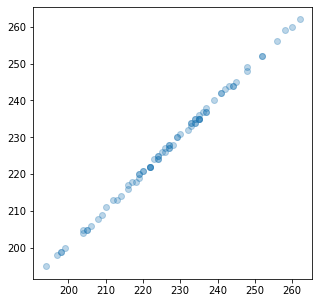

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(widths, heights, alpha=0.3)

#### 3.3.2 히스토그램으로 출력하기

**가로 크기 히스토그램**

가로 크기를 히스토그램으로 나타내어 봅니다.

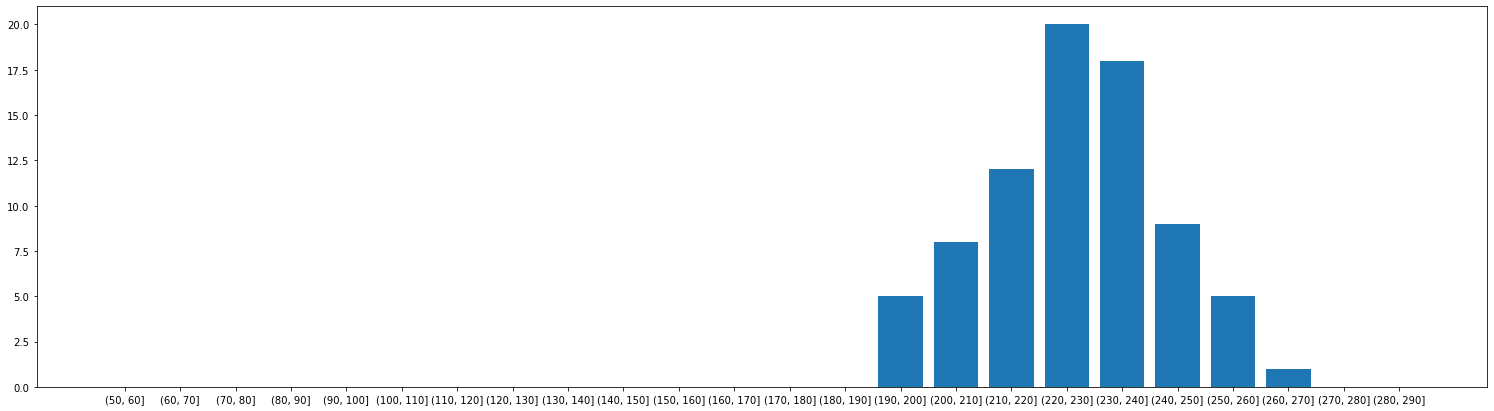

In [ ]:
cut_widths = pd.cut(widths, np.arange(50, 300, 10)).value_counts()

fig, ax = plt.subplots(figsize=(26, 7))
ax.bar(range(len(cut_widths)),cut_widths.values)
ax.set_xticks(range(len(cut_widths)))
ax.set_xticklabels(cut_widths.index)
fig.show()

## **세로 크기 히스토그램**

동일한 방법으로 세로 크기를 히스토그램을 나타내어 봅니다.

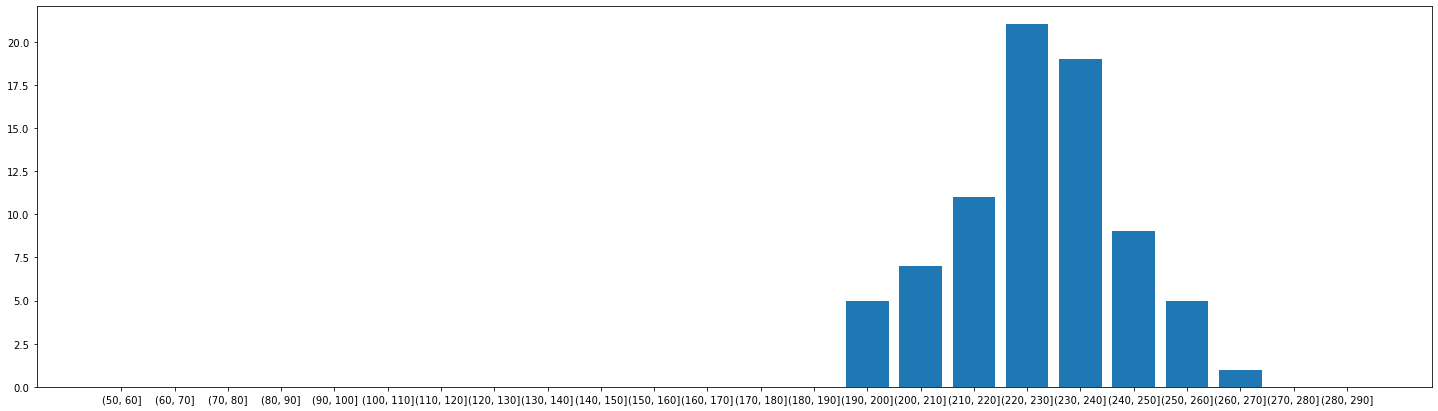

In [ ]:
cut_heights = pd.cut(heights, np.arange(50, 300, 10)).value_counts()

fig, ax = plt.subplots(figsize=(25,7))
ax.bar(range(len(cut_heights)),cut_heights.values)
ax.set_xticks(range(len(cut_heights)))
ax.set_xticklabels(cut_heights.index)
fig.show()

#### 3.3.3 모델에 사용할 이미지 크기 결정하기 
모델에 학습을 시키기 위해서는 같은 크기로 만들어야 합니다. 만약, 너무 큰 이미지를 사용한다면 메모리 사용이 많아지고 학습이 비효율적일 수 있으며, 너무 작은 이미지를 사용하면 정보손실이 발생할 수 있습니다. 그래서 위의 그래프를 참고해서 적절한 크기를 찾아보겠습니다.

주로 200~250 사이에 데이터가 많이 모여 있는 것을 볼 수 있습니다. 따라서, 해당 값들의 중간값이라고 생각되는 크기를 사용해서 가로와 세로 길이를 각각 225로 설정하겠습니다.

# 4. 데이터 전 처리(2)
---


### 4.1 통일된 이미지 크기로 이미지 가져오기

이제 통일된 이미지 크기로 이미지를 가져오겠습니다. 이미지는 위에 결정한대로 가로, 세로의 길이를 225로 통일시킵니다. 그리고 이미지를 가져올 때 마스크를 쓴 사진의 라벨은 1로 하고, 마스크를 쓰지 않은 사진의 라벨은 0으로 구분합니다.

In [ ]:
image_height = 225
image_width = 225

images = []
labels = []

for non_mask in non_mask_list:
    image = load_img('./non_mask/'+non_mask, target_size=(image_height, image_width))
    image = img_to_array(image)
    images.append(image)
    labels.append(0)
    
for mask in mask_list:
    image = load_img('./mask/'+mask, target_size=(image_height, image_width))
    image = img_to_array(image)
    images.append(image)
    labels.append(1)

`images[0]`의 shape를 출력하니 가로 225, 세로 225, 채널 3인 것을 확인 할 수 있습니다.

In [ ]:
images[0].shape

(225, 225, 3)

### 4.2 데이터 분리하기

가져온 이미지를 `sklearn.model_selection`에서 `train_test_split()`를 사용하여 훈련용 데이터와 검증용 데이터, 테스트용 데이터를 6:2:2 비율로 나눕니다. 그리고 `shuffle` 매개변수를 `True` 로 설정하여 분리 시 마스크를 쓴 사진과 마스크를 쓰지 않은 사진이 섞이도록 합니다. random seed 값인 `random_state` 는 0으로 설정하겠습니다.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X = np.array(images) / 255. # 255 로 나누어주어 0~1 사이의 값으로 만들어줍니다.
y = np.array(labels) 
x_train, x_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size=0.4, shuffle = True, random_state = 0)
x_val, x_test, y_val, y_test = train_test_split(x_valid_test, y_valid_test, test_size=0.5, shuffle = True, random_state = 0)
print('훈련용 데이터 개수:', len(x_train))
print('검증용 데이터 개수:', len(x_val))
print('테스트용 데이터 개수:', len(x_test))

훈련용 데이터 개수: 46
검증용 데이터 개수: 16
테스트용 데이터 개수: 16


`y_train`을 출력해보니 사진이 잘 섞인 것을 확인 할 수 있습니다.

In [ ]:
y_train

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1])

## 5. 딥러닝 모델 만들고 학습하기

---

### 5.1 CNN 모델 설정

이제 딥러닝에 사용할 CNN 모델을 구현합니다. 2개층의 convolutional layer 와 2개층의 dense layer 로 구성합니다. 각 layer 사이에는 rate를 0.25로 설정한 dropout 을 배치해주었고, 각 convolutional layer 다음에는 max pooling을 넣습니다. 중간 layer 들의 활성함수는 relu로, 마지막 layer의 활성함수는 softmax로 해줍니다.

In [ ]:
image_channel = 3
model = Sequential([    
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(image_height, image_width, image_channel)),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(rate=0.25),
    
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(rate=0.25),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(rate=0.25),
    Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 223, 223, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 93312)             0

### 5.2 모델 컴파일하기

모델의 출력은 마스크를 썼는지 안 썼는지를 나타내야 하기 때문에 loss 함수는 `sparse_categorical_crossentropy`로 설정하고 optimizer는 `adam`을 사용하게 하였습니다.

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

### 5.3 모델 학습시키기

이렇게 만들진 모델에 학습 데이터와 검증 데이터를 사용하여 학습시켜보겠습니다. 

In [ ]:
EPOCHS = 5

history = model.fit(x_train, 
                    y_train,
                    validation_data = (x_val, y_val),
                    epochs=EPOCHS, 
                   )

Epoch 1/5
2/2 [==============================] - 2s 653ms/step - loss: 1.2068 - accuracy: 0.5435 - val_loss: 0.1884 - val_accuracy: 0.9375
Epoch 2/5
2/2 [==============================] - 1s 490ms/step - loss: 0.2609 - accuracy: 0.9171 - val_loss: 0.1204 - val_accuracy: 1.0000
Epoch 3/5
2/2 [==============================] - 1s 479ms/step - loss: 0.2376 - accuracy: 0.8963 - val_loss: 0.2822 - val_accuracy: 0.9375
Epoch 4/5
2/2 [==============================] - 1s 487ms/step - loss: 0.0588 - accuracy: 0.9751 - val_loss: 0.2586 - val_accuracy: 0.9375
Epoch 5/5
2/2 [==============================] - 1s 473ms/step - loss: 0.0570 - accuracy: 0.9855 - val_loss: 0.1630 - val_accuracy: 0.9375


### 5.4 학습 수행시 Accuracy와 Loss 변화 그래프로 확인하기



모델을 학습하면서 출력되는 손실값과 정확도를 확인할 수 있습니다. 

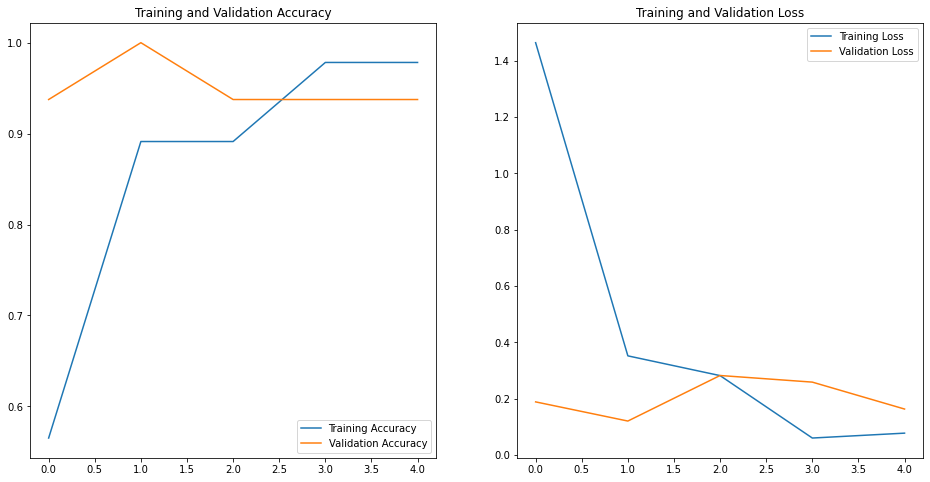

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 6. 결과 확인

학습시킨 모델을 활용하여 테스트합니다.

### 6.1 모델 성능 평가 및 예측

학습이 잘 되었는지 평가용 데이터로 확인해봅시다.

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

print('test set accuracy: ', test_accuracy)

test set accuracy:  0.9375


정확도가 93.8%로 나옵니다. 
실제 이미지를 출력해서 실제 라벨과 예측값을 출력해보겠습니다.

In [ ]:
test_prediction = np.argmax(model.predict(x_test), axis=-1)

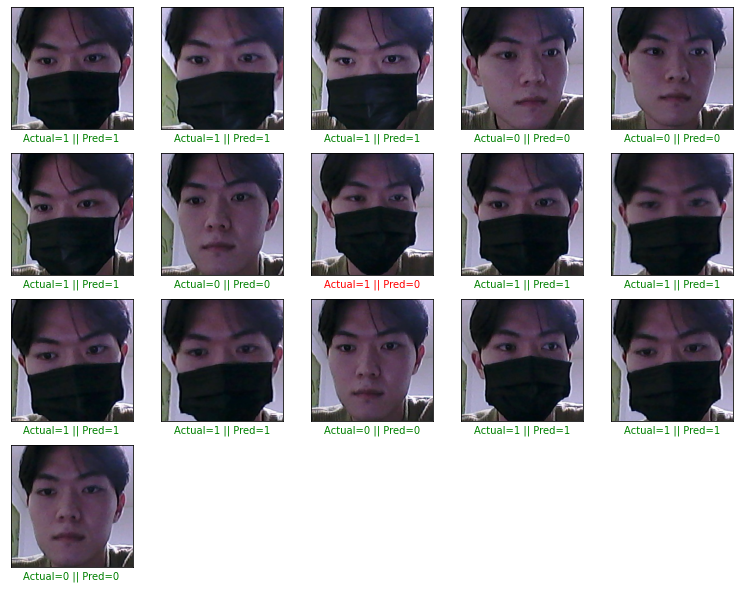

In [ ]:
plt.figure(figsize = (13, 13))

start_index = 0
for i in range(len(y_test)):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = test_prediction[start_index + i]
    actual = y_test[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    pimg = array_to_img(x_test[start_index + i, :, :, ::-1])
    plt.imshow(pimg)
plt.show()

마지막으로 confusion matrix를 시각화하여 분류 학습 결과를 확인해 보겠습니다. 

<AxesSubplot:>

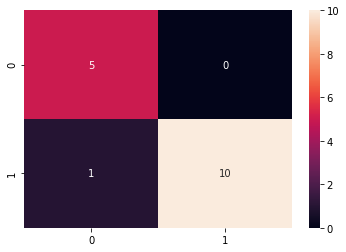

In [ ]:
cm = confusion_matrix(y_test, test_prediction)
sns.heatmap(cm, annot = True)

## 더 해보기
---

모델의 성능을 높이기 위해서는 어떤 방법을 사용할 수 있을지(ex. 데이터의 개수 늘리기 / 모델 layer 변경하기 / eochs 수 늘리기 등..)와 실시간으로 웹캠을 활용하여 마스크 판별을 표시하는 프로그램은 어떻게 구현할 수 있을지 고민해봅니다.

모델의 성능을 높이기 위해 사용할 수 있는 다양한 기법들이 있지만, 이번 시간에는 **데이터 증강 기법 (data augmentation)** 을 소개하겠습니다.

딥러닝 모델 훈련을 위한 데이터는 많을수록 좋습니다. 그러나, 현실적으로 데이터를 무한히 많이 수집하는 것이 어려울 수 있습니다. 그럴 때 데이터 증강 기법을 많이 사용하는데요, 한정적인 데이터를 약간씩 수정하여 훈련 데이터를 늘리는 기법입니다. 

모델 훈련 시에 랜덤하게 이미지를 좌우 반전시키는 `RandomFlip()`, 이미지를 랜덤한 각도로 회전시키는 `RandomRotation()`, 그리고 이미지의 랜덤한 영역을 특정 사이즈로 크롭하는 `RandomCrop()` 기법을 사용해봅니다.

In [ ]:
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.05),
  RandomCrop(220, 220),
])

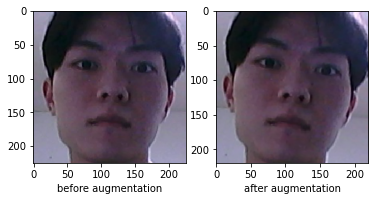

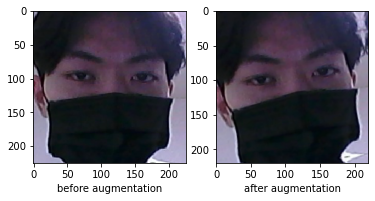

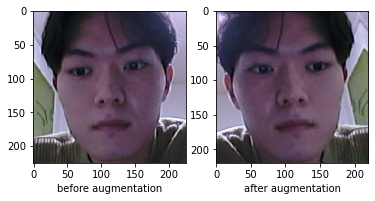

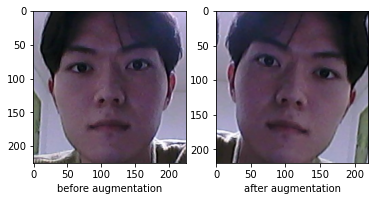

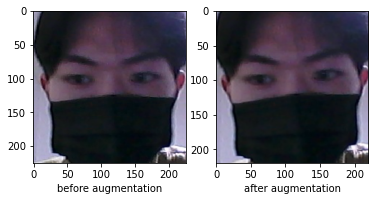

In [ ]:
for i in range(5):
    augmented_image = data_augmentation(x_train[i:i+1])
    plt.subplot(1,2,1)
    plt.imshow(x_train[i, :, :, ::-1])
    plt.xlabel('before augmentation')
    plt.subplot(1,2,2)
    plt.imshow(augmented_image[0, :, :, ::-1])
    plt.xlabel('after augmentation')
    plt.show()

위에서 했던 것과 동일하게 모델을 정의하되, `data_augmentation` 을 맨 앞에 추가하여 데이터 증강기법을 사용해봅니다.

In [ ]:
image_channel = 3
model = Sequential([    
    data_augmentation,
    
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(image_height, image_width, image_channel)),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(rate=0.25),
    
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(rate=0.25),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(rate=0.25),
    Dense(2, activation='softmax')
])

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [ ]:
EPOCHS = 5

history = model.fit(x_train, 
                    y_train,
                    validation_data = (x_val, y_val),
                    epochs=EPOCHS, 
                   )

Epoch 1/5
2/2 [==============================] - 3s 761ms/step - loss: 0.6914 - accuracy: 0.6639 - val_loss: 0.5953 - val_accuracy: 0.4375
Epoch 2/5
2/2 [==============================] - 1s 484ms/step - loss: 0.4458 - accuracy: 0.7074 - val_loss: 0.4283 - val_accuracy: 1.0000
Epoch 3/5
2/2 [==============================] - 1s 562ms/step - loss: 0.3702 - accuracy: 0.8505 - val_loss: 0.3881 - val_accuracy: 0.9375
Epoch 4/5
2/2 [==============================] - 1s 491ms/step - loss: 0.2108 - accuracy: 0.9316 - val_loss: 0.3477 - val_accuracy: 0.9375
Epoch 5/5
2/2 [==============================] - 1s 478ms/step - loss: 0.2145 - accuracy: 0.8361 - val_loss: 0.2149 - val_accuracy: 1.0000


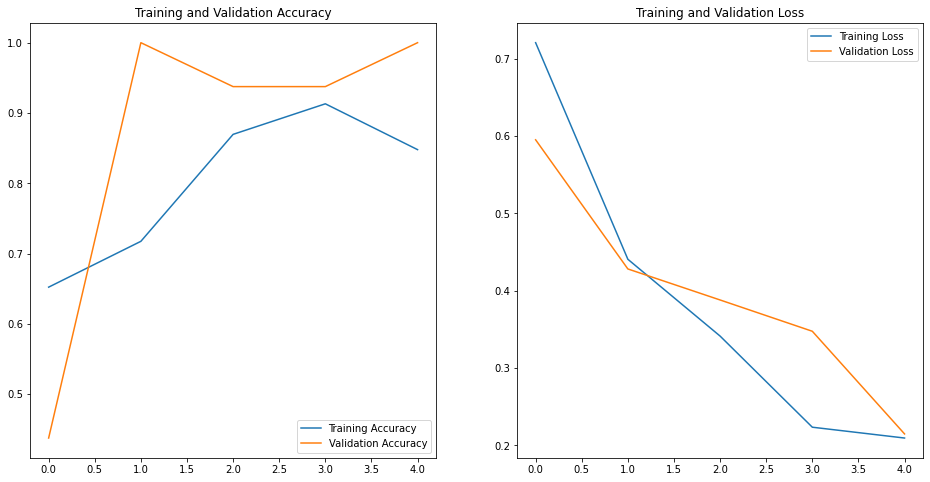

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

print('test set accuracy: ', test_accuracy)

test set accuracy:  1.0


In [ ]:
test_prediction = np.argmax(model.predict(x_test), axis=-1)

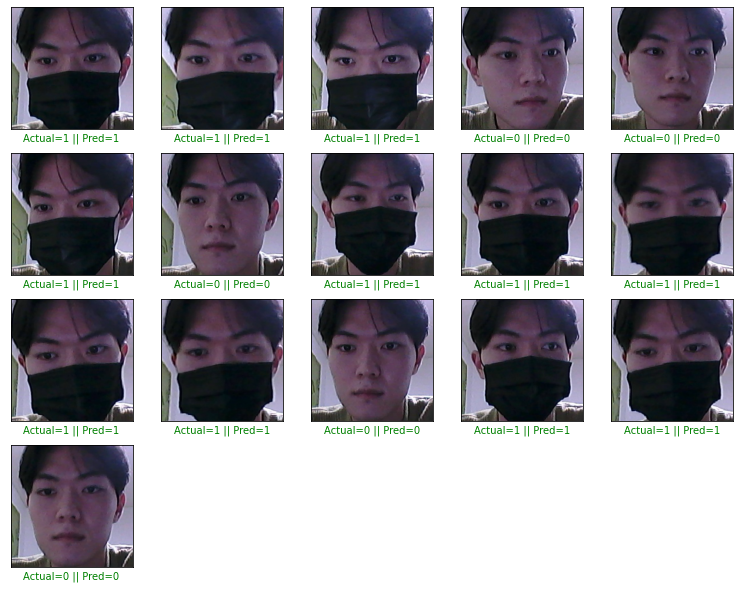

In [ ]:
plt.figure(figsize = (13, 13))

start_index = 0
for i in range(len(y_test)):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = test_prediction[start_index + i]
    actual = y_test[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    pimg = array_to_img(x_test[start_index + i, :, :, ::-1])
    plt.imshow(pimg)
plt.show()